In [1]:
# Disclaimer. This very simple example is meant to provide the basic use-case for the library. 
# Here we exchange a discrete field between two 2D triangulations, using a variational transfer operator
# which allows to extend outside the source domain.

# Note that, in realistic scenarios the input/output would be handled differently. 
# ParMoonlith is to be integrated with another library that has mesh-management functionalities, parallel algebra.
# A typical integration would have the following steps:
# 1) The mesh and function-spaces from the client library are converted to the ParMoonlith data-structures
# 2) ParMoonlith computes the transfer operator, which consists of a collection of matrices (1 to 3).
# 3) The matrices of the transfer operator are converted to matrices of the client library.
# Optionally, the client library can be tightly integrated with ParMoonolith for avoiding copies, 
# however the adaptation is more demanding in terms of development time.

In [2]:
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as mtri
import subprocess

In [3]:
# code for reading a simple mesh from disk
def read_tri_mesh(tri_path, vert_path, dim):
    # Read triangulation
    f = open(tri_path, 'r')
    data = f.read()
    f.close()

    idx = np.fromstring(data, dtype=int, sep=' ') - 1
    triangles = np.reshape(idx, (-1, 3))
    
    # Read points
    f = open(vert_path, 'r')
    data = f.read()
    f.close()

    coords = np.fromstring(data, dtype=float, sep=' ')
    xy = np.reshape(coords, (-1, dim))

    x = xy[:, 0]
    y = xy[:, 1]
    
    triang = mtri.Triangulation(x, y, triangles)
    return triang

In [4]:
# set-up the paths for data and executable
src_dim = 2

# source mesh
src_path_tri = '../data/triangle_105.tri'
src_path_vert = '../data/triangle_105.vert'

# destination mesh
dest_dim = 2
dest_path_tri = '../data/square_200.tri'
dest_path_vert = '../data/square_200.vert'

# paths for functions
src_function_path = 'src_function.txt'
dest_function_path = 'dest_function.txt'

# ParMoonolith example binary
path_executable = "../../build_opt/examples/example_variational_transfer_no_covering"

In [5]:
# read the source mesh
src_mesh = read_tri_mesh(src_path_tri, src_path_vert, src_dim)

In [6]:
# read the destination mesh
dest_mesh = read_tri_mesh(dest_path_tri, dest_path_vert, dest_dim)

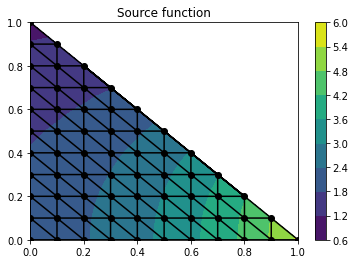

In [7]:
# create function, write to disk, and plot
x = src_mesh.x
y = src_mesh.y

# z = np.cos(1.5 * x) * np.cos(1.5 * y)
z = 1 + np.exp(1.5 * x) * np.cos(1.5 * y)

f = open(src_function_path, "w")
for v in z:
    f.write(str(v) + "\n")
f.close()

fig, axs = plt.subplots()
c = axs.tricontourf(src_mesh, z)
axs.triplot(src_mesh, 'ko-')
t = axs.set_title('Source function')
cbar = fig.colorbar(c)

In [12]:
# Using the example at `examples/example_variational_transfer_no_covering.cpp`
# call exectuable
args = (path_executable, src_path_tri, dest_path_tri, src_function_path, dest_function_path)
popen = subprocess.Popen(args, stdout=subprocess.PIPE, encoding='ascii')
popen.wait()
output = popen.stdout.read()

print("----------------------------------------")
print("ParMoonolith output:")
print("----------------------------------------")
print(output)
print("----------------------------------------")

----------------------------------------
ParMoonolith output:
----------------------------------------
using:
master:
../data/triangle_105.tri
slave:
../data/square_200.tri
init: 0.00107124
found_matches: 100 false positives: 19
time ParL2TransferNoCovering::assemble: 0.00135643
vol: 0.5 sum(B): 0.5 sum(D): 0.5
0.5 == 0.5 == expected_value: 0.5
66 <= expected_value: 121
Read input from src_function.txt n  = 66 == 66
Wrote output to dest_function.txt

----------------------------------------


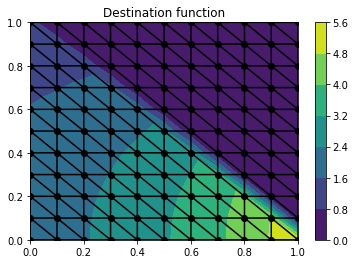

In [9]:
# Read and plot projected function

x = dest_mesh.x
y = dest_mesh.y

f = open(dest_function_path, 'r')
data = f.read()
f.close()
z = np.fromstring(data, dtype=float, sep=' ')

fig, axs = plt.subplots()
c = axs.tricontourf(dest_mesh, z)
axs.triplot(dest_mesh, 'ko-')
t = axs.set_title('Destination function')

cbar = fig.colorbar(c)